# Homework 1
### Import needed libraries and define confusion matrix function

In [ ]:
# Basics
import random
import numpy as np
import pandas as pd

# Train and test
from sklearn.feature_extraction.text import *
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.naive_bayes import *
from sklearn import svm
from sklearn import tree
from sklearn import ensemble

# Evaluation
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Function to draw pretty confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        pass
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print ('Libraries imported')

Libraries imported


### Load dataset

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# To help find right directory
%ls drive/MyDrive/Homework1_duplicates_dataset/homework_classification/blindtest.json

blindtest.json  dataset.json


In [ ]:
## Dataset with duplicates '/content/drive/MyDrive/Homework1_duplicates_dataset/homework_classification/dataset.json'
## Dataset without duplicates '/content/drive/MyDrive/Homework1_dataset/nodup_classification/noduplicatedataset.json'
filename = '/content/drive/MyDrive/Homework1_duplicates_dataset/homework_classification/dataset.json'
dataset = pd.read_json(filename, lines=True)

# Return first samples
dataset.head()

,id,semantic,lista_asm,cfg
0,828,string,"['jmp qword ptr [rip + 0x220882]', 'jmp qword ...","{'directed': True, 'graph': [], 'nodes': [{'id..."
1,11786,math,"['ucomisd xmm2, xmm2', 'jp 0x40', 'ucomisd xmm...","{'directed': True, 'graph': [], 'nodes': [{'id..."
2,12621,encryption,"['push rbx', 'mov r8d, ecx', 'mov qword ptr [r...","{'directed': True, 'graph': [], 'nodes': [{'id..."
3,11166,math,"['mov qword ptr [rsp - 0x10], rbx', 'mov qword...","{'directed': True, 'graph': [], 'nodes': [{'id..."
4,10432,sort,"['jmp qword ptr [rip + 0x200ba2]', 'jmp qword ...","{'directed': True, 'graph': [], 'nodes': [{'id..."


In [ ]:
# Print number of samples
print('File loaded. Number of samples: ', len(dataset))

File loaded. Number of samples:  14397


### Extract features 
CLASSIC BAG-OF-WORDS

In [ ]:
# Remove from lista_asm the first "[" and last "]", and split the instructions
assembly_instructions = dataset['lista_asm'].apply(lambda lista: lista[1:-1]).apply(lambda lista: lista.split("', "))
assembly_instructions.head()

0    ['jmp qword ptr [rip + 0x220882], 'jmp qword p...
1    ['ucomisd xmm2, xmm2, 'jp 0x40, 'ucomisd xmm0,...
2    ['push rbx, 'mov r8d, ecx, 'mov qword ptr [rsp...
3    ['mov qword ptr [rsp - 0x10], rbx, 'mov qword ...
4    ['jmp qword ptr [rip + 0x200ba2], 'jmp qword p...
Name: lista_asm, dtype: object

In [ ]:
# Take the assembly instruction and replace "'" with "" where it's still present
assembly_instruction_list = assembly_instructions.apply(lambda lista: [e.split(" ", 1)[0] for e in lista])
assembly_instruction_list = assembly_instruction_list.apply(lambda lista: [e.replace("'", '') for e in lista])
print(assembly_instruction_list, type(assembly_instruction_list))

0        [jmp, jmp, jmp, push, mov, mov, cmp, jge, push...
1        [ucomisd, jp, ucomisd, jp, pxor, ucomisd, jae,...
2        [push, mov, mov, mov, xor, nop, mov, lea, sar,...
3        [mov, mov, sub, movsd, mov, mov, movsd, movsd,...
4        [jmp, jmp, jmp, push, push, sub, mov, xor, cal...
                               ...                        
14392    [test, push, je, test, push, je, test, je, tes...
14393    [push, mov, sub, movsd, movsd, mov, mov, xor, ...
14394    [push, mov, sub, lea, lea, mov, mov, mov, mov,...
14395    [push, push, push, push, push, push, sub, mov,...
14396    [test, jle, lea, shr, lea, sar, jmp, movsxd, m...
Name: lista_asm, Length: 14397, dtype: object <class 'pandas.core.series.Series'>


In [ ]:
# Create a string of instructions for each element of the data set
assembly_instruction_strings = assembly_instruction_list.apply(", ".join)
print(assembly_instruction_strings, type(assembly_instruction_strings))

0        jmp, jmp, jmp, push, mov, mov, cmp, jge, push,...
1        ucomisd, jp, ucomisd, jp, pxor, ucomisd, jae, ...
2        push, mov, mov, mov, xor, nop, mov, lea, sar, ...
3        mov, mov, sub, movsd, mov, mov, movsd, movsd, ...
4        jmp, jmp, jmp, push, push, sub, mov, xor, call...
                               ...                        
14392    test, push, je, test, push, je, test, je, test...
14393    push, mov, sub, movsd, movsd, mov, mov, xor, m...
14394    push, mov, sub, lea, lea, mov, mov, mov, mov, ...
14395    push, push, push, push, push, push, sub, mov, ...
14396    test, jle, lea, shr, lea, sar, jmp, movsxd, mo...
Name: lista_asm, Length: 14397, dtype: object <class 'pandas.core.series.Series'>


### Data preprocessing

In [ ]:
# VECTORIZER (bag-of-words method)
vectorizer = CountVectorizer()
bag_of_words_vector = vectorizer.fit_transform(assembly_instruction_strings)
#print(vectorizer.get_feature_names())

Y_labels = dataset['semantic'].values

print(bag_of_words_vector)
print("=============================================")
print(Y_labels)

# For evaluation
class_names = np.array([str(c) for c in dataset['semantic']])
class_names = np.unique(class_names)
print("Class names: ", class_names)

  (0, 72)	7
  (0, 142)	2
  (0, 86)	46
  (0, 27)	8
  (0, 69)	1
  (0, 170)	1
  (0, 67)	2
  (0, 70)	1
  (0, 73)	4
  (0, 11)	6
  (0, 1)	4
  (0, 100)	4
  (0, 125)	2
  (0, 147)	2
  (1, 72)	3
  (1, 142)	2
  (1, 86)	2
  (1, 170)	1
  (1, 67)	3
  (1, 73)	1
  (1, 11)	1
  (1, 147)	2
  (1, 175)	5
  (1, 78)	2
  (1, 143)	4
  :	:
  (14395, 108)	1
  (14395, 80)	1
  (14395, 71)	1
  (14395, 60)	7
  (14396, 72)	3
  (14396, 86)	30
  (14396, 27)	17
  (14396, 69)	8
  (14396, 170)	2
  (14396, 70)	1
  (14396, 73)	4
  (14396, 100)	12
  (14396, 147)	1
  (14396, 174)	3
  (14396, 181)	1
  (14396, 108)	1
  (14396, 80)	12
  (14396, 150)	1
  (14396, 165)	1
  (14396, 13)	2
  (14396, 62)	1
  (14396, 71)	2
  (14396, 68)	1
  (14396, 23)	2
  (14396, 20)	2
['string' 'math' 'encryption' ... 'encryption' 'sort' 'sort']
Class names:  ['encryption' 'math' 'sort' 'string']


### Spit dataset into train and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bag_of_words_vector, Y_labels, test_size=0.3, random_state=0)

print("Size of training set: %d" %X_train.shape[0])
print("Size of test set: %d" %X_test.shape[0])

Size of training set: 10077
Size of test set: 4320


### Create classifier

In [ ]:
# MULTINOMIAL
#classifier = MultinomialNB()
#print("Multinomial Naive Bayes classifier created")

# SVM
#kernel_name  = 'rbf' # 'linear', 'poly', 'rbf', 'sigmoid'
#classifier = svm.SVC(C=1.0, kernel=kernel_name, degree=4, gamma='scale')
#print("SVM " + kernel_name + " classifier created")

# DECISION TREE
#classifier = tree.DecisionTreeClassifier(random_state=5)
#print("Decision tree classifier created")

# RANDOM FOREST
classifier = ensemble.RandomForestClassifier(n_estimators=150)
print("Random forest classifier created")


Random forest classifier created


### Fit model and make predictions

In [ ]:
model = classifier.fit(X_train, y_train) 
print("Model fitted")
y_pred = model.predict(X_test)
print("Model prections done")

Model fitted
Model prections done


### Evaluation

              precision    recall  f1-score   support

  encryption       1.00      0.99      1.00       796
        math       1.00      1.00      1.00      1360
        sort       1.00      1.00      1.00      1229
      string       1.00      1.00      1.00       935

    accuracy                           1.00      4320
   macro avg       1.00      1.00      1.00      4320
weighted avg       1.00      1.00      1.00      4320

Confusion matrix, without normalization
[[ 792    0    4    0]
 [   0 1360    0    0]
 [   0    0 1229    0]
 [   0    0    0  935]]


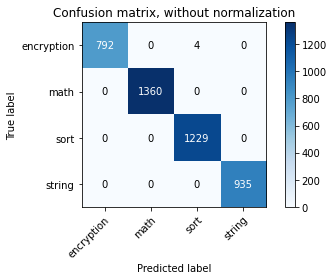

In [ ]:
# Print results
print(classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=False)

### Make predictions on blind set and write it into a file

In [ ]:
# Read blind data set
filename_blind = '/content/drive/MyDrive/Homework1_duplicates_dataset/homework_classification/blindtest.json'
dataset_blind = pd.read_json(filename_blind, lines=True)

# Return first samples
dataset_blind.head()


,id,lista_asm,cfg
0,10351,"['jmp qword ptr [rip + 0x203b72]', 'jmp qword ...","{'directed': True, 'graph': [], 'nodes': [{'id..."
1,14513,"['sub rsp, 0x28', 'mov rax, qword ptr fs:[0x28...","{'directed': True, 'graph': [], 'nodes': [{'id..."
2,1767,"['jmp qword ptr [rip + 0x200bc2]', 'jmp qword ...","{'directed': True, 'graph': [], 'nodes': [{'id..."
3,9384,"['jmp qword ptr [rip + 0x2177ea]', 'jmp qword ...","{'directed': True, 'graph': [], 'nodes': [{'id..."
4,3018,"['ucomisd xmm1, xmm1', 'movapd xmm7, xmm0', 'm...","{'directed': True, 'graph': [], 'nodes': [{'id..."


In [ ]:
# Print number of samples
print('File loaded. Number of samples: ', len(dataset_blind))

# Remove from lista_asm the first "[" and last "]", and split the instructions
assembly_instructions = dataset_blind['lista_asm'].apply(lambda lista: lista[1:-1]).apply(lambda lista: lista.split("', "))
assembly_instructions.head()

# Take the assembly instruction and replace "'" with "" where it's still present
assembly_instruction_list = assembly_instructions.apply(lambda lista: [e.split(" ", 1)[0] for e in lista])
assembly_instruction_list = assembly_instruction_list.apply(lambda lista: [e.replace("'", '') for e in lista])
print(assembly_instruction_list, type(assembly_instruction_list))

# Create a string of instructions for each element of the data set
assembly_instruction_strings = assembly_instruction_list.apply(", ".join)
print(assembly_instruction_strings, type(assembly_instruction_strings))

# VECTORIZER (bag-of-words method)
bag_of_words_vector_blind = vectorizer.transform(assembly_instruction_strings)

y_pred_blind = model.predict(bag_of_words_vector_blind)

print(y_pred_blind)


File loaded. Number of samples:  757
0      [jmp, jmp, jmp, jmp, push, push, push, push, p...
1      [sub, mov, mov, xor, ucomisd, jp, lea, lea, le...
2      [jmp, jmp, jmp, push, mov, mov, call, test, je...
3      [jmp, jmp, jmp, jmp, mov, cmp, jl, push, push,...
4      [ucomisd, movapd, movapd, movapd, jp, ucomisd,...
                             ...                        
752    [ucomisd, setp, ucomisd, setp, or, jne, ucomis...
753    [lea, mov, mov, mov, nop, mov, xor, movzx, dec...
754    [push, push, sub, lea, cmp, ja, push, sub, mov...
755    [push, mov, sub, movsd, movsd, mov, mov, movsd...
756    [push, push, sub, movsd, movsd, ucomisd, jp, m...
Name: lista_asm, Length: 757, dtype: object <class 'pandas.core.series.Series'>
0      jmp, jmp, jmp, jmp, push, push, push, push, pu...
1      sub, mov, mov, xor, ucomisd, jp, lea, lea, lea...
2      jmp, jmp, jmp, push, mov, mov, call, test, je,...
3      jmp, jmp, jmp, jmp, mov, cmp, jl, push, push, ...
4      ucomisd, movapd, mova

In [ ]:
print(len(y_pred_blind))
for i in y_pred_blind:
  print(i)

757
encryption
math
string
string
math
string
sort
encryption
sort
math
math
math
sort
string
string
math
string
string
math
sort
math
string
encryption
math
encryption
string
string
math
math
sort
string
sort
sort
sort
string
sort
string
math
sort
string
sort
math
sort
math
sort
sort
sort
string
string
sort
string
math
math
string
math
string
math
math
math
math
encryption
sort
math
string
string
sort
math
sort
sort
sort
sort
sort
string
string
math
sort
sort
sort
sort
sort
sort
encryption
math
string
string
math
string
math
encryption
math
string
string
string
sort
sort
string
math
encryption
encryption
encryption
math
sort
sort
sort
encryption
math
math
math
math
sort
encryption
string
sort
string
string
encryption
math
sort
sort
string
encryption
math
math
encryption
math
sort
math
string
sort
encryption
encryption
string
sort
sort
string
sort
math
string
encryption
math
math
string
math
math
sort
sort
math
sort
encryption
math
math
math
string
string
encryption
string
string
math


In [ ]:
txt_results = open("1759992.txt", mode='w')
for e in y_pred_blind:
 txt_results.write(e + "\n")

txt_results.close()
print("Results written in txt file")

Results written in txt file
